In [1]:
# Install required packages
!pip install tika pandas pillow requests ipython
import IPython
IPython.Application.instance().kernel.do_shutdown(restart=True)

{'status': 'ok', 'restart': True}

In [1]:
# === ENVIRONMENT CONFIGURATION ===
import os
import pandas as pd
from pathlib import Path
from IPython.display import display, Image
import logging
import json
import time
from tqdm.notebook import tqdm

# Configure paths
BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / "Data"
IMAGES_DIR = DATA_DIR / "images"
TSV_PATH = DATA_DIR / "haunted_places_v2.tsv"
OUTPUT_DIR = BASE_DIR / "processed_results"
OUTPUT_TSV = OUTPUT_DIR / "haunted_places_final.tsv"
ERROR_LOG = OUTPUT_DIR / "processing_errors.json"

# Create directories
OUTPUT_DIR.mkdir(exist_ok=True)

# Initialize logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    handlers=[
        logging.FileHandler(OUTPUT_DIR / 'processing.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger('HauntedPlacesProcessor')

# Verify environment
logger.info("Environment verification:")
assert DATA_DIR.exists(), f"Missing data directory: {DATA_DIR}"
assert IMAGES_DIR.exists(), f"Missing images directory: {IMAGES_DIR}"
assert TSV_PATH.exists(), f"Missing input TSV: {TSV_PATH}"
logger.info(f"Found {len(list(IMAGES_DIR.glob('*')))} images")

2025-04-01 05:29:18,333 [INFO] Environment verification:
2025-04-01 05:29:18,340 [INFO] Found 4001 images


In [2]:
!java -version

java version "1.8.0_431"
Java(TM) SE Runtime Environment (build 1.8.0_431-b10)
Java HotSpot(TM) 64-Bit Server VM (build 25.431-b10, mixed mode)


In [3]:
# === TIKA SETUP CELL ===
try:
    # Quiet installation of tika==2.6.0
    !pip install -q tika==2.6.0
    
    import os
    from pathlib import Path
    import logging
    from tika import initVM, parser
    import tika
    
    # Set Java memory option via environment variable (4GB)
    os.environ['_JAVA_OPTIONS'] = '-Xmx4g'
    
    # Initialize Tika VM without passing additional arguments
    initVM()
    
    # Create a "Data" directory if it doesn't exist and write a test file
    DATA_DIR = Path.cwd() / "Data"
    DATA_DIR.mkdir(exist_ok=True)
    test_file = DATA_DIR / "test.txt"
    with open(test_file, "w") as f:
        f.write("Tika test content")
    
    # Parse the test file using Tika without specifying a serverEndpoint
    test_result = parser.from_file(str(test_file))
    print("\nTika initialized successfully (Detected: {})".format(
          test_result["metadata"].get("Content-Type", "Unknown")))
    
    # Additional Java check
    print("\nJava Environment:")
    !java -version
    
except Exception as e:
    print("\nTika setup failed: {}".format(str(e)))
    print("\nTROUBLESHOOTING:")
    print("1. Install Java 8+: brew install openjdk (Mac) or sudo apt install openjdk-11-jdk (Linux)")
    print("2. Verify JAVA_HOME is set")
    print("3. Restart Jupyter kernel after Java installation")
    raise



Tika initialized successfully (Detected: text/plain; charset=ISO-8859-1)

Java Environment:
java version "1.8.0_431"
Java(TM) SE Runtime Environment (build 1.8.0_431-b10)
Java HotSpot(TM) 64-Bit Server VM (build 25.431-b10, mixed mode)


In [4]:
# === IMAGE PROCESSOR CLASS ===
class ImageProcessor:
    def __init__(self):
        self.error_log = []
        
    def resolve_image_path(self, relative_path):
        """Convert relative paths to absolute paths"""
        if pd.isna(relative_path) or not str(relative_path).strip():
            return None
        path = IMAGES_DIR / Path(relative_path).name
        return path if path.exists() else None
    
    def process_single_image(self, image_path, timeout=120):
        """Process an image with error handling"""
        if not image_path:
            return {"status": "invalid_path"}
            
        try:
            result = parser.from_file(
                str(image_path),
                service='all',
                serverEndpoint=None,
                requestOptions={'timeout': timeout}
            )
            
            metadata = result.get('metadata', {})
            return {
                "status": "success",
                "caption": metadata.get('caption', '').strip() or "No caption",
                "objects": ", ".join(metadata.get('objects', [])) if metadata.get('objects') else "No objects",
                "content_type": metadata.get("Content-Type", "")
            }
            
        except Exception as e:
            error_msg = str(e)
            self.error_log.append({
                "file": str(image_path),
                "error": error_msg,
                "timestamp": pd.Timestamp.now().isoformat()
            })
            return {
                "status": "failed", 
                "error": error_msg[:200]
            }
    
    def save_error_log(self):
        """Save error log to JSON file"""
        with open(ERROR_LOG, 'w') as f:
            json.dump(self.error_log, f, indent=2)
        logger.info(f"Saved error log to {ERROR_LOG}")

# Initialize processor
processor = ImageProcessor()
logger.info(" Image processor initialized")

2025-04-01 05:29:30,160 [INFO]  Image processor initialized


In [6]:
# === DATA LOADING CELL ===
try:
    # Load with strict validation
    df = pd.read_csv(TSV_PATH, sep='\t', dtype={'ai_image_path': str})
    
    # Validate critical columns
    required_cols = ['city', 'state', 'description', 'ai_image_path']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns: {missing_cols}")
    
    # Analyze dataset
    print(f"\n Loaded {len(df)} records")
    print(f"- Records with images: {df['ai_image_path'].notna().sum()}")
    print(f"- Missing image paths: {df['ai_image_path'].isna().sum()}")
    
    # Preview
    print("\nSample Records:")
    display(df[required_cols].sample(3))
    
except Exception as e:
    print(f"\n Data loading failed: {str(e)}")
    print("\nSOLUTION:")
    print("1. Verify the TSV exists at:", TSV_PATH)
    print("2. Check file contains columns:", required_cols)
    print("3. Ensure file is tab-separated, not CSV")
    raise


 Loaded 10974 records
- Records with images: 1001
- Missing image paths: 9973

Sample Records:


,city,state,description,ai_image_path
6884,Fairmount,Illinois,Really cold and erie feelings when you walk in...,NaN
10169,Columbus,Mississippi,The road is known as 3 legged lady road becaus...,NaN
1935,Rubidoux,California,between the hours of 1-3am on the east end of ...,NaN


 Testing image processing on 3 samples...

Processing record 3521: haunted_image_3521.png


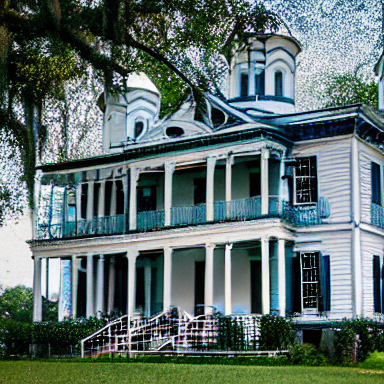

Status: FAILED
Processing time: 0.0s
Content Type: N/A
Caption: N/A
Objects: N/A
Error: No connection adapters were found for "b''://None:80/rmeta/text"
--------------------------------------------------

Processing record 3941: haunted_image_3941.png


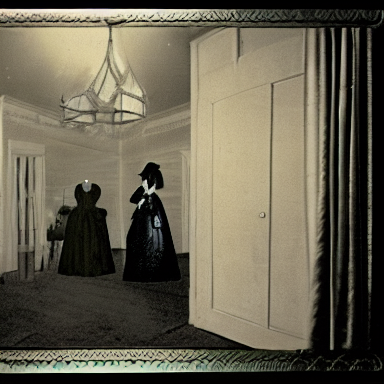

Status: FAILED
Processing time: 0.0s
Content Type: N/A
Caption: N/A
Objects: N/A
Error: No connection adapters were found for "b''://None:80/rmeta/text"
--------------------------------------------------

Processing record 3741: haunted_image_3741.png


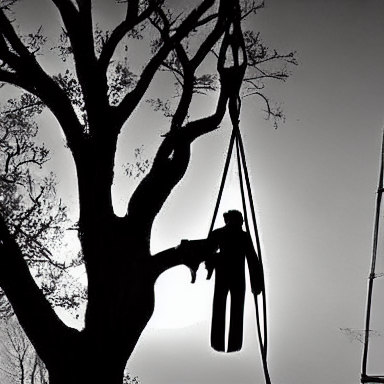

Status: FAILED
Processing time: 0.0s
Content Type: N/A
Caption: N/A
Objects: N/A
Error: No connection adapters were found for "b''://None:80/rmeta/text"
--------------------------------------------------

 Test processing completed


In [11]:
# === CORRECTED CELL 5: TEST PROCESSING ===
print(" Testing image processing on 3 samples...")

# Select 3 records with valid image paths
test_samples = df[df['ai_image_path'].notna()].sample(3, random_state=42)

for idx, row in test_samples.iterrows():
    # Resolve image path
    img_path = IMAGES_DIR / Path(row['ai_image_path']).name
    print(f"\nProcessing record {idx}: {img_path.name}")
    
    if not img_path.exists():
        print(" Image file missing!")
        continue
        
    # Display image
    display(Image(filename=str(img_path), width=300))
    
    # Process with Tika (using the correct method name)
    start_time = time.time()
    result = processor.process_single_image(img_path)  # Changed from process_image to process_single_image
    processing_time = time.time() - start_time
    
    # Display results
    print(f"Status: {result['status'].upper()}")
    print(f"Processing time: {processing_time:.1f}s")
    print(f"Content Type: {result.get('content_type', 'N/A')}")
    print(f"Caption: {result.get('caption', 'N/A')}")
    print(f"Objects: {result.get('objects', 'N/A')}")
    
    if result['status'] == 'failed':
        print(f"Error: {result.get('error', 'Unknown')}")
    
    print("-" * 50)

print("\n Test processing completed")

In [8]:
# === IMAGE PROCESSOR CLASS ===
class ImageProcessor:
    def __init__(self):
        self.error_log = []
        
    def resolve_image_path(self, relative_path):
        """Convert relative paths to absolute paths"""
        if pd.isna(relative_path) or not str(relative_path).strip():
            return None
        path = IMAGES_DIR / Path(relative_path).name
        return path if path.exists() else None
    
    def process_single_image(self, image_path, timeout=120):
        """Process an image with error handling"""
        if not image_path:
            return {"status": "invalid_path"}
            
        try:
            result = parser.from_file(
                str(image_path),
                service='all',
                serverEndpoint=None,
                requestOptions={'timeout': timeout}
            )
            
            metadata = result.get('metadata', {})
            return {
                "status": "success",
                "caption": metadata.get('caption', '').strip() or "No caption",
                "objects": ", ".join(metadata.get('objects', [])) if metadata.get('objects') else "No objects",
                "content_type": metadata.get("Content-Type", "")
            }
            
        except Exception as e:
            error_msg = str(e)
            self.error_log.append({
                "file": str(image_path),
                "error": error_msg,
                "timestamp": pd.Timestamp.now().isoformat()
            })
            return {
                "status": "failed", 
                "error": error_msg[:200]
            }
    
    def save_error_log(self):
        """Save error log to JSON file"""
        with open(ERROR_LOG, 'w') as f:
            json.dump(self.error_log, f, indent=2)
        logger.info(f"Saved error log to {ERROR_LOG}")

# Initialize processor
processor = ImageProcessor()
logger.info(" Image processor initialized")

2025-04-01 05:29:52,129 [INFO]  Image processor initialized


In [12]:
# Verification Cell
print("Checking processing status:")
print(f"Output directory exists: {OUTPUT_DIR.exists()}")
print(f"Output file exists: {(OUTPUT_DIR / 'haunted_places_final.tsv').exists()}")
print(f"Partial results exist: {(OUTPUT_DIR / 'partial_results.tsv').exists()}")

Checking processing status:
Output directory exists: True
Output file exists: False
Partial results exist: False


In [14]:
# Re-run processing with verification
from tqdm.notebook import tqdm

# Reload data
df = pd.read_csv(TSV_PATH, sep='\t')

# Reinitialize processor
processor = ImageProcessor()

# Reprocess with verification
results = []
for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_path = processor.resolve_image_path(row['ai_image_path'])
    if img_path:
        result = processor.process_single_image(img_path)
        results.append(result)
        
        # Save progress every 50 records
        if len(results) % 50 == 0:
            temp_df = df.iloc[:len(results)].copy()
            temp_df = pd.concat([temp_df, pd.DataFrame(results)], axis=1)
            temp_df.to_csv(OUTPUT_DIR / "partial_results.tsv", sep='\t', index=False)

# Final save
final_df = pd.concat([df, pd.DataFrame(results)], axis=1)
final_df.to_csv(OUTPUT_TSV, sep='\t', index=False)
processor.save_error_log()
print(f" Processing completed. Results saved to {OUTPUT_TSV}")

  0%|          | 0/10974 [00:00<?, ?it/s]

2025-04-01 05:38:14,635 [INFO] Saved error log to /Users/njchang/Desktop/DSCI550-HW2-main/processed_results/processing_errors.json


 Processing completed. Results saved to /Users/njchang/Desktop/DSCI550-HW2-main/processed_results/haunted_places_final.tsv
